## ViT
ViT was first paper to introduce transformer for images. It served as a replacement for CNN which gave SOTA performance on image classification. 
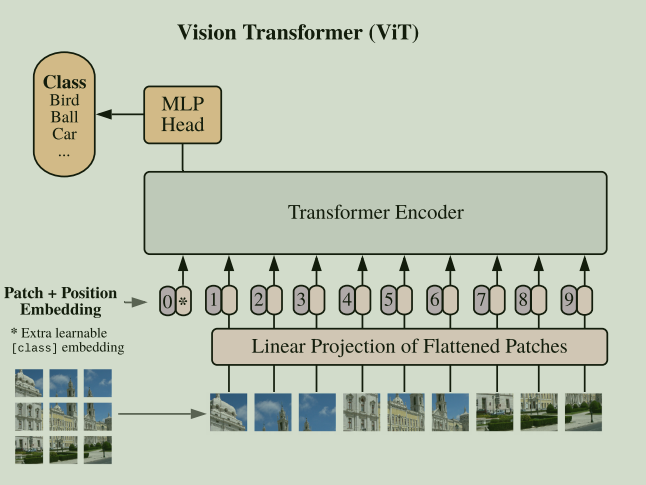  
Here I will train ViT from scratch.  
Following pipeline:  
1. Dataset MNIST (having handwritten numbers 0-9)
2. Patch embedding
3. Transformer encoder
4. MLP head
5. Vision Transformer
6. Training loop
7. Validation
8. Random visualization

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as dataloader
import torch.nn as nn

In [15]:
#transformation of downloaded PIL images to tensor format
transformation_op = transforms.Compose([transforms.ToTensor()])

In [16]:
#import dataset. torchvision has inbuilt MNIT dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformation_op)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformation_op)

In [17]:
#variables
num_classes = 10    #num of classification classes
batch_size = 64
num_channels = 1
img_size = 28
patch_size = 7      #MNIT image is of shape (28, 28)
num_patches = (img_size // patch_size)**2       #since num of patches = (width * height)/(patch_size * patch_size)
embedding_dim = 64
attention_heads = 4
transformer_blocks = 4
learning_rate = 0.001
mlp_hidden_nodes = 128
epoch = 5

In [18]:
#define dataset batches (64 images in each batch)
train_loader = dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = dataloader.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### Patch Embedding

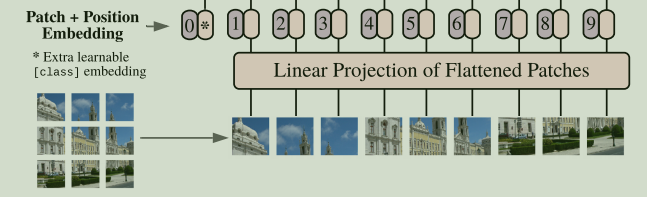  

our example
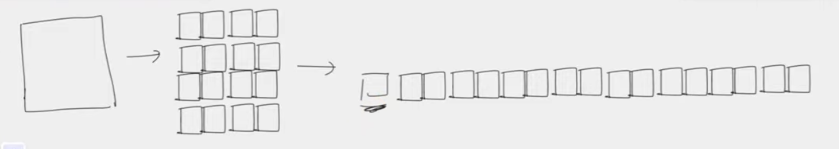

In [19]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        #makes sure that we are just inheriting the class and adding on top\
        #of it rather than changing
        super().__init__()
        #we are producing patches from the initial images which are non-overlapping\
        #which is why kernel_size and strides both are = patch_size.\
        # i/p image (batch_size, num_channels, 28, 28) ---> each patch embedding (batch_size (64), embde_dim (64), 28/4, 28/4)   
        self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        #patch embedding creation (64, 64, 4, 4)
        x = self.patch_embed(x)
        #flattening (64, 64, 16)
        x = x.flatten(2)
        x = x.transpose(1,2)    #(64, 16, 64)
      
        return x
         

### Transformer encoder
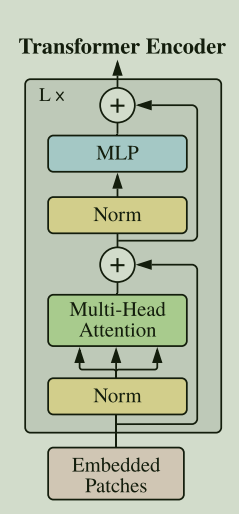

In [20]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        #layer normalization 
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        #multihead attention
        self.multihead_attn = nn.MultiheadAttention(embedding_dim, attention_heads, batch_first=True)
        #MLP
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_hidden_nodes),
            nn.GELU(),
            nn.Linear(mlp_hidden_nodes, embedding_dim)
        )
        
    def forward(self, x):
        skip_conn1 = x[:]
        x = self.layer_norm1(x)
        x = self.multihead_attn(x, x, x)[0]
        x = x + skip_conn1

        skip_conn2 = x[:]
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = x + skip_conn2

        return x


### MLP head
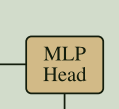

In [21]:
class MLP_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.mlp_head = nn.Linear(embedding_dim, num_classes)
    
    def forward(self, x):
        x = self.layer_norm1(x)
        x = self.mlp_head(x)

        return x

### ViT model

In [22]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        #[CLS]
        self.cls_token = nn.Parameter(torch.randn(1,1,embedding_dim))       #learnable parameters are defined like this
        #position embedding
        self.position_embedding = nn.Parameter(torch.randn(1,1+num_patches,embedding_dim))
        #cls passed into MLP head
        self.transformer_blks = nn.Sequential(
            *[TransformerEncoder() for _ in range(transformer_blocks)]
        )
        self.mlp_head = MLP_head()

    def forward(self, x):
        x = self.patch_embedding(x)
        cls_tok = self.cls_token.expand(x.size(0), -1, -1)   #(batch_size, num_cls_per_batch, dim_cls)
        x = torch.cat((cls_tok, x), dim=1)
        x = x + self.position_embedding
        x = self.transformer_blks(x)
        x = x[:,0]
        x = self.mlp_head(x)

        return x


### Training code

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [24]:
for ep in range(epoch):
    model.train()
    total_loss = 0
    correct_epo = 0 
    total_ep = 0
    print("Epoch: ",ep+1)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0*correct/labels.size(0)
        correct_epo += correct
        total_ep += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epo / total_ep
    print(f"===> Epoch {ep+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

Epoch:  1
Batch 0: Loss = 2.4091, Accuracy = 10.94%
Batch 100: Loss = 0.5242, Accuracy = 87.50%
Batch 200: Loss = 0.2485, Accuracy = 93.75%
Batch 300: Loss = 0.4129, Accuracy = 84.38%
Batch 400: Loss = 0.1217, Accuracy = 96.88%
Batch 500: Loss = 0.3190, Accuracy = 90.62%
Batch 600: Loss = 0.1933, Accuracy = 95.31%
Batch 700: Loss = 0.2399, Accuracy = 92.19%
Batch 800: Loss = 0.1261, Accuracy = 95.31%
Batch 900: Loss = 0.0686, Accuracy = 96.88%
===> Epoch 1 Summary: Total Loss = 348.7814, Accuracy = 88.33%
Epoch:  2
Batch 0: Loss = 0.1488, Accuracy = 92.19%
Batch 100: Loss = 0.1046, Accuracy = 96.88%
Batch 200: Loss = 0.0972, Accuracy = 96.88%
Batch 300: Loss = 0.0710, Accuracy = 98.44%
Batch 400: Loss = 0.1075, Accuracy = 98.44%
Batch 500: Loss = 0.1074, Accuracy = 96.88%
Batch 600: Loss = 0.2341, Accuracy = 92.19%
Batch 700: Loss = 0.1968, Accuracy = 93.75%
Batch 800: Loss = 0.0202, Accuracy = 100.00%
Batch 900: Loss = 0.1456, Accuracy = 95.31%
===> Epoch 2 Summary: Total Loss = 120.5

### Validation

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> val accuracy: {test_acc:.2f}%")


==> val accuracy: 97.80%


### Random Visualization

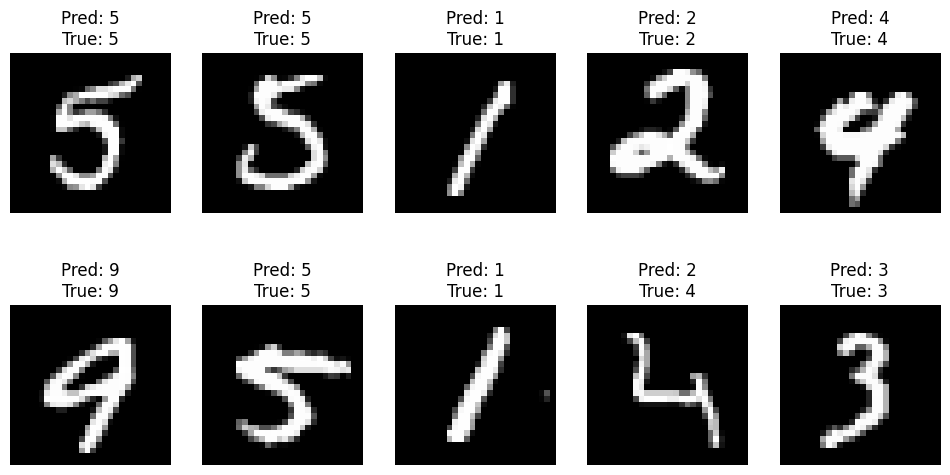

In [28]:
import matplotlib.pyplot as plt

model.eval()
images, labels = next((iter(val_loader)))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis("off")